In [4]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import seaborn as sns

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device
    print(f"Using {device}")



/users/k23070952/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/users/k23070952/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using <class 'torch.device'>


In [3]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 67.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("✅ CUDA is available!")
        print(f"→ Device count: {torch.cuda.device_count()}")
        print(f"→ Current device: {torch.cuda.current_device()}")
        print(f"→ Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        print(f"→ Device capability: {torch.cuda.get_device_capability(torch.cuda.current_device())}")
        device = torch.device("cuda")
    else:
        print("⚠️ CUDA not available. Falling back to CPU.")
        device = torch.device("cpu")
    return device

# 사용
device = check_cuda()


✅ CUDA is available!
→ Device count: 1
→ Current device: 0
→ Device name: NVIDIA A100-SXM4-40GB
→ Device capability: (8, 0)


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Integer

columns = [
    'Stages', '_Lr1', '_Hr1',
    '_Lr2', '_Hr2', '_T_hex',
    '_Lr3', '_Hr3',
    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', 'Shortcut_Time',
    'Rigorous_CAPEX', 'Rigorous_OPEX', 'Rigorous_AceticAcidWt', 'Rigorous_Time'
]

# Create dataframe
results=pd.read_csv("/users/k23070952/MultiFidelity-ProcessOpt/3. Data/results_250327.csv")
results_df = pd.DataFrame(results.values, columns=columns)
results_df



,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,33.159892,0.791180,0.353830,0.353268,0.457194,320.045902,0.404425,0.286343,1.7362,3.5006,...,2.0,2.0,2.452838,3.0,1.0,0.970765,1.6828,3.5805,0.232864,15.028605
3057,5.843494,0.764640,0.567782,0.839752,0.862830,337.919680,0.289938,0.057054,3.1313,17.9336,...,9.0,8.0,13.754399,-1.0,0.0,2.625655,3.3894,20.4207,0.497016,69.754515
3058,32.487513,0.452585,0.329244,0.959149,0.956480,273.600871,0.870761,0.153479,2.7351,8.6322,...,13.0,12.0,5.624850,4.0,1.0,0.981317,2.5579,9.0346,0.716376,71.535613
3059,20.536314,0.874326,0.889799,0.328094,0.505928,298.837605,0.848039,0.814387,1.4743,0.8924,...,2.0,2.0,0.252298,8.0,1.0,0.251915,1.3347,0.9415,0.171821,6.263263


R² Score: 0.5199 (1.0이면 완전 선형, 0에 가까울수록 비선형)


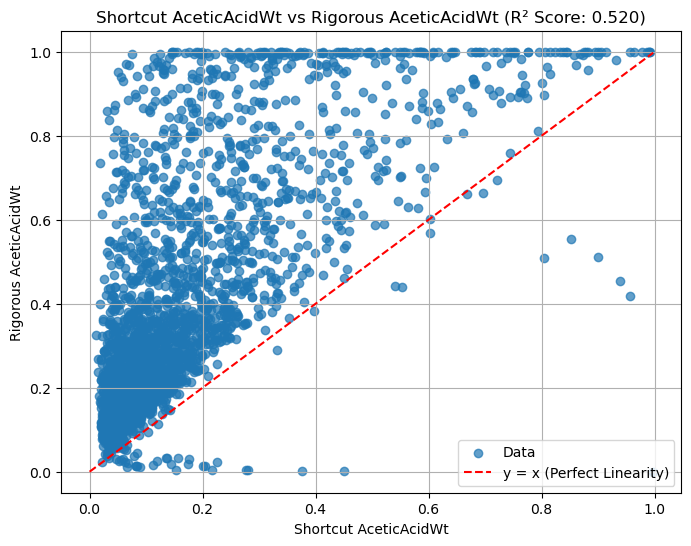

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Filter out invalid or NaN results for CAPEX
valid_results = results_df.dropna(subset=['Shortcut_AceticAcidWt', 'Rigorous_AceticAcidWt'])
valid_results = valid_results[(valid_results['Shortcut_AceticAcidWt'] > 0) & (valid_results['Rigorous_AceticAcidWt'] > 0) &
                                (valid_results['Shortcut_AceticAcidWt'] < 1) & (valid_results['Rigorous_AceticAcidWt'] < 1)]

# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_AceticAcidWt'], valid_results['Rigorous_AceticAcidWt'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_AceticAcidWt'].min(), valid_results['Rigorous_AceticAcidWt'].min())
max_val = min(valid_results['Shortcut_AceticAcidWt'].max(), valid_results['Rigorous_AceticAcidWt'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_AceticAcidWt']].values
y = valid_results['Rigorous_AceticAcidWt'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut AceticAcidWt')
plt.ylabel('Rigorous AceticAcidWt')
plt.title(f'Shortcut AceticAcidWt vs Rigorous AceticAcidWt (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


R² Score: 0.4999 (1.0이면 완전 선형, 0에 가까울수록 비선형)


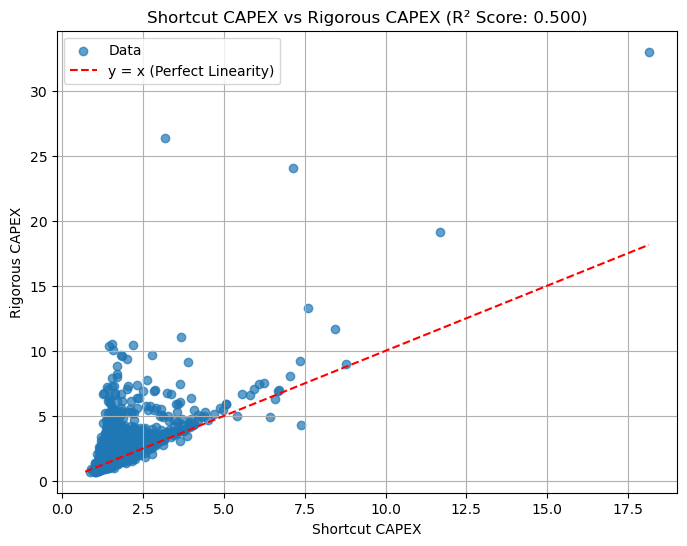

In [19]:
# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_CAPEX'], valid_results['Rigorous_CAPEX'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_CAPEX'].min(), valid_results['Rigorous_CAPEX'].min())
max_val = min(valid_results['Shortcut_CAPEX'].max(), valid_results['Rigorous_CAPEX'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_CAPEX']].values
y = valid_results['Rigorous_CAPEX'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut CAPEX')
plt.ylabel('Rigorous CAPEX')
plt.title(f'Shortcut CAPEX vs Rigorous CAPEX (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


R² Score: 0.9746 (1.0이면 완전 선형, 0에 가까울수록 비선형)


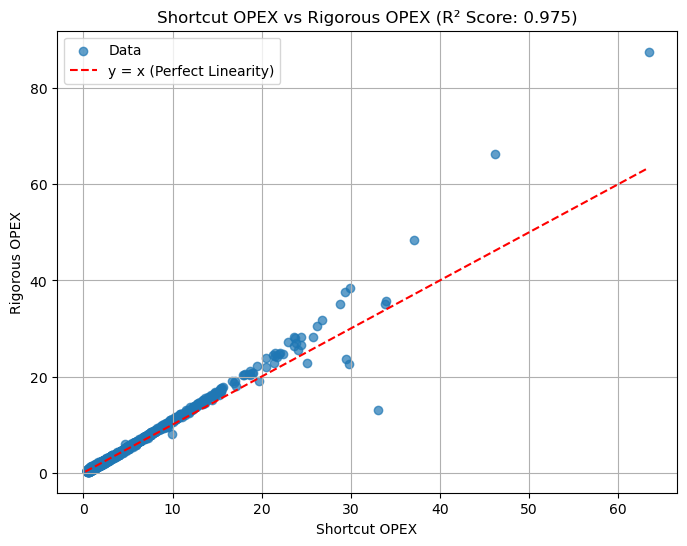

In [20]:
# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_OPEX'], valid_results['Rigorous_OPEX'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_OPEX'].min(), valid_results['Rigorous_OPEX'].min())
max_val = min(valid_results['Shortcut_OPEX'].max(), valid_results['Rigorous_OPEX'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_OPEX']].values
y = valid_results['Rigorous_OPEX'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut OPEX')
plt.ylabel('Rigorous OPEX')
plt.title(f'Shortcut OPEX vs Rigorous OPEX (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
valid_results

,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,33.159892,0.791180,0.353830,0.353268,0.457194,320.045902,0.404425,0.286343,1.7362,3.5006,...,2.0,2.0,2.452838,3.0,1.0,0.970765,1.6828,3.5805,0.232864,15.028605
3057,5.843494,0.764640,0.567782,0.839752,0.862830,337.919680,0.289938,0.057054,3.1313,17.9336,...,9.0,8.0,13.754399,-1.0,0.0,2.625655,3.3894,20.4207,0.497016,69.754515
3058,32.487513,0.452585,0.329244,0.959149,0.956480,273.600871,0.870761,0.153479,2.7351,8.6322,...,13.0,12.0,5.624850,4.0,1.0,0.981317,2.5579,9.0346,0.716376,71.535613
3059,20.536314,0.874326,0.889799,0.328094,0.505928,298.837605,0.848039,0.814387,1.4743,0.8924,...,2.0,2.0,0.252298,8.0,1.0,0.251915,1.3347,0.9415,0.171821,6.263263


## 1. 리그레이션 모델링


In [29]:
def prepare_data(df):
    input_cols = ['Stages', '_Lr1', '_Hr1', '_Lr2', '_Hr2', '_T_hex', '_Lr3', '_Hr3']

    target_cols = [
        'Rigorous_CAPEX'
    ]

    X = df[input_cols].values
    y = df[target_cols].values
    return X, y, target_cols

def prepare_data_add_shortcut(df):
    input_cols = [ 'Stages', '_Lr1', '_Hr1',
                    '_Lr2', '_Hr2', '_T_hex',
                    '_Lr3', '_Hr3',
                    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
                    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
                    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
                    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', ]
    
    target_cols = ['Rigorous_CAPEX']

    X = df[input_cols].values
    y = df[target_cols].values
    return X, y, target_cols


def run_linear_regression_with_validation(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    for i in range(y.shape[1]):
        model = LinearRegression()
        model.fit(X_train, y_train[:, i])

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
        test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
        train_r2s.append(r2_score(y_train[:, i], y_train_pred))
        test_r2s.append(r2_score(y_test[:, i], y_test_pred))

        models.append(model)
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }

def run_random_forest_with_validation(X, y, test_size=0.4, random_state=1004):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    # Bayesian Optimization for hyperparameter tuning
    opt = BayesSearchCV(
        RandomForestRegressor(random_state=random_state),
        search_spaces={
            'n_estimators': Integer(50, 300),
            'max_depth': Integer(3, 15),
            'min_samples_leaf': Integer(1, 10),
        },
        n_iter=50,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    opt.fit(X_train, y_train[:, i])
    best_model = opt.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
    test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
    train_r2s.append(r2_score(y_train[:, i], y_train_pred))
    test_r2s.append(r2_score(y_test[:, i], y_test_pred))

    models.append(best_model)
    train_preds.append(y_train_pred)
    test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }



def run_xgboost_with_bayesian_optimization(X, y, test_size=0.2, random_state=1004, device='gpu', n_iter=100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    for i in range(y.shape[1]):
        opt = BayesSearchCV(
                            XGBRegressor(
                                random_state=random_state,
                                tree_method="gpu_hist",  
                                predictor="gpu_predictor", 
                                device="cuda", 
                                verbosity=0
                            ),
                            search_spaces={
                                'n_estimators': Integer(50, 300),
                                'max_depth': Integer(3, 15),
                                'min_child_weight': Integer(1, 10),
                            },
                            n_iter=n_iter,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            random_state=random_state,
                            n_jobs=-1,
                            verbose=1
                        )
        opt.fit(X_train, y_train[:, i])
        best_model = opt.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
        test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
        train_r2s.append(r2_score(y_train[:, i], y_train_pred))
        test_r2s.append(r2_score(y_test[:, i], y_test_pred))

        models.append(best_model)
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }


def plot_predictions_with_split(y_train_true, y_train_pred, y_test_true, y_test_pred,
                                 target_cols, train_mse, train_r2, test_mse, test_r2,
                                 title="Model Prediction Results"):
    n_targets = len(target_cols)
    ncols = 3
    nrows = int(np.ceil(n_targets / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i in range(n_targets):
        ax = axes[i]
        ax.scatter(y_train_true[:, i], y_train_pred[:, i], color='blue', alpha=0.6, label="Train")
        ax.scatter(y_test_true[:, i], y_test_pred[:, i], color='orange', alpha=0.6, label="Test")
        ax.plot([min(y_train_true[:, i].min(), y_test_true[:, i].min()),
                 max(y_train_true[:, i].max(), y_test_true[:, i].max())],
                [min(y_train_true[:, i].min(), y_test_true[:, i].min()),
                 max(y_train_true[:, i].max(), y_test_true[:, i].max())], 'r--')
        ax.set_title(f"{target_cols[i]}")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")

        ax.text(0.05, 0.95,
                f"Train MSE: {train_mse[i]:.3f}\nTrain R²: {train_r2[i]:.3f}\n"
                f"Test MSE: {test_mse[i]:.3f}\nTest R²: {test_r2[i]:.3f}",
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle="round", fc="white", alpha=0.5))
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_single_target_with_split(y_train_true, y_train_pred, y_test_true, y_test_pred,
                                   target_name, train_mse, train_r2, test_mse, test_r2,
                                   title="Model Prediction Results"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, color='blue', alpha=0.6, label="Train")
    plt.scatter(y_test_true, y_test_pred, color='orange', alpha=0.6, label="Test")

    y_min = min(y_train_true.min(), y_test_true.min())
    y_max = max(y_train_true.max(), y_test_true.max())
    plt.plot([y_min, y_max], [y_min, y_max], 'r--')

    plt.title(f"{title}\nTarget: {target_name}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

    plt.text(0.05, 0.95,
             f"Train MSE: {train_mse:.3f}\nTrain R²: {train_r2:.3f}\n"
             f"Test MSE: {test_mse:.3f}\nTest R²: {test_r2:.3f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round", fc="white", alpha=0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

PCC 분석

In [23]:
def plot_correlation_matrix(df, title="Correlation Matrix"):
    corr = df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8},)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return corr


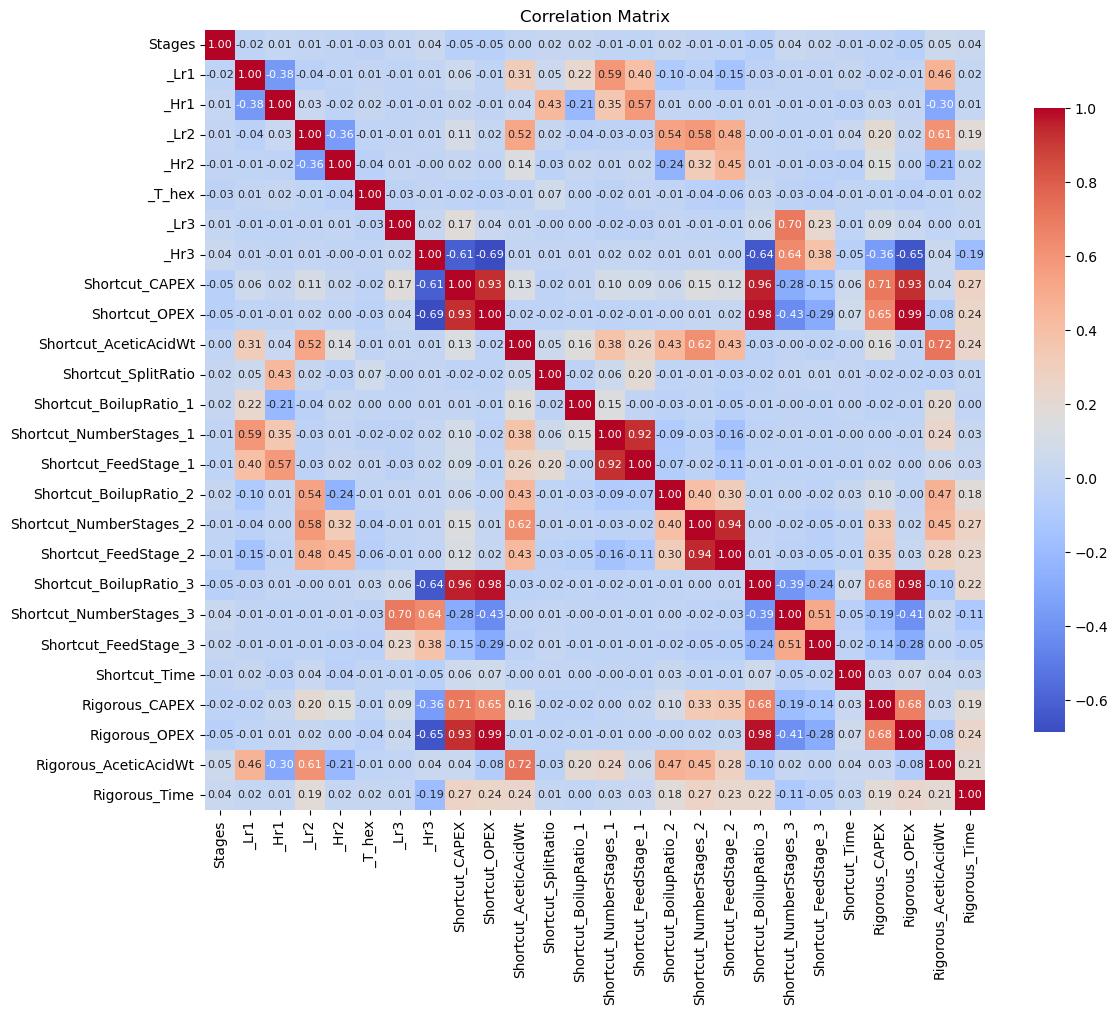

,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
Stages,1.000000,-0.019909,0.014019,0.007033,-0.007441,-0.027600,0.012383,0.039958,-0.050361,-0.053529,...,-0.006433,-0.008352,-0.052133,0.038548,0.022717,-0.005806,-0.019198,-0.051196,0.051131,0.039017
_Lr1,-0.019909,1.000000,-0.375836,-0.035345,-0.012711,0.009639,-0.012554,0.005915,0.060279,-0.012407,...,-0.041026,-0.151264,-0.025369,-0.005979,-0.005882,0.023479,-0.020391,-0.011386,0.464820,0.017056
_Hr1,0.014019,-0.375836,1.000000,0.031410,-0.015317,0.023257,-0.013347,-0.008083,0.023239,-0.005091,...,0.002886,-0.010530,0.005849,-0.013795,-0.012005,-0.030632,0.027826,0.005391,-0.304481,0.014586
_Lr2,0.007033,-0.035345,0.031410,1.000000,-0.363323,-0.012673,-0.007713,0.009833,0.108803,0.017889,...,0.577210,0.481257,-0.001578,-0.011135,-0.012978,0.035132,0.196829,0.021217,0.609976,0.187719
_Hr2,-0.007441,-0.012711,-0.015317,-0.363323,1.000000,-0.038209,0.007343,-0.002495,0.021024,0.002175,...,0.316465,0.452153,0.007069,-0.005747,-0.029795,-0.037469,0.150039,0.004524,-0.209960,0.015542
_T_hex,-0.027600,0.009639,0.023257,-0.012673,-0.038209,1.000000,-0.027279,-0.006765,-0.018528,-0.032717,...,-0.044779,-0.057282,0.029834,-0.026311,-0.035315,-0.007771,-0.008526,-0.037051,-0.009678,0.024358
_Lr3,0.012383,-0.012554,-0.013347,-0.007713,0.007343,-0.027279,1.000000,0.019067,0.174158,0.040758,...,-0.006309,-0.011938,0.062055,0.701840,0.227119,-0.010071,0.089056,0.041379,0.004299,0.012595
_Hr3,0.039958,0.005915,-0.008083,0.009833,-0.002495,-0.006765,0.019067,1.000000,-0.610094,-0.686931,...,0.005774,0.000311,-0.635752,0.642627,0.380471,-0.048223,-0.360539,-0.653683,0.039384,-0.186268
Shortcut_CAPEX,-0.050361,0.060279,0.023239,0.108803,0.021024,-0.018528,0.174158,-0.610094,1.000000,0.927634,...,0.148103,0.123064,0.956174,-0.280168,-0.149631,0.057901,0.707031,0.931226,0.039177,0.267526
Shortcut_OPEX,-0.053529,-0.012407,-0.005091,0.017889,0.002175,-0.032717,0.040758,-0.686931,0.927634,1.000000,...,0.013616,0.022688,0.979655,-0.433659,-0.290271,0.071556,0.649866,0.987238,-0.078993,0.242850


In [24]:
plot_correlation_matrix(valid_results)

## Modelling-RF

In [ ]:

# 데이터프레임 불러오기 (예시)
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)

    # Linear Regression 실행
result = run_random_forest_with_validation(X, y)  # y.shape = (n_samples, 1)

plot_single_target_with_split(
    y_train_true=result['y_train'].flatten(),
    y_train_pred=result['y_train_pred'].flatten(),
    y_test_true=result['y_test'].flatten(),
    y_test_pred=result['y_test_pred'].flatten(),
    target_name='Rigorous_CAPEX',
    train_mse=result['train_mse'][0],
    train_r2=result['train_r2'][0],
    test_mse=result['test_mse'][0],
    test_r2=result['test_r2'][0],
    title="Random Forest (Train/Test)"
)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

## Modelling-XGB

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [11, 3, 149]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [11, 7, 76]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [12, 5, 134]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [13, 6, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [3, 8, 141]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [13, 3, 198]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [5, 6, 94]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 7, 50] before, using random point [10, 8, 268]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 2, 223]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [15, 5, 298]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 4, 75]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 3, 190]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 6, 129]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [13, 6, 102]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 8, 218]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 5, 236]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [11, 10, 292]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 3, 231]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [11, 8, 192]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 5, 259]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 5, 131]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [8, 8, 178]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 2, 156]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 7, 257]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 6, 241]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 7, 227]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [15, 7, 128]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [8, 4, 224]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [8, 6, 216]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [3, 2, 86]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [3, 2, 172]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [15, 9, 238]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 3, 248]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 8, 224]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 8, 242]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 4, 205]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 10, 166]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 5, 190]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 9, 271]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [13, 3, 157]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 104]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 1, 115]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [4, 5, 100]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 167]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 8, 147]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 2, 135]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 7, 243]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 177]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 9, 133]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 1, 297]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 6, 223]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 3, 197]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 3, 109]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 7, 56]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 7, 170]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 128]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [4, 5, 207]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 9, 201]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 5, 221]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [3, 2, 182]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [4, 7, 216]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [9, 3, 276]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [5, 4, 68]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [9, 7, 96]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [11, 7, 135]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [5, 3, 185]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [13, 3, 99]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [3, 9, 66]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [11, 6, 255]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [5, 9, 180]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [10, 9, 92]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [6, 6, 235]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [9, 8, 88]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [11, 4, 173]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [14, 4, 296]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [10, 7, 161]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [13, 3, 161]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [14, 10, 232]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


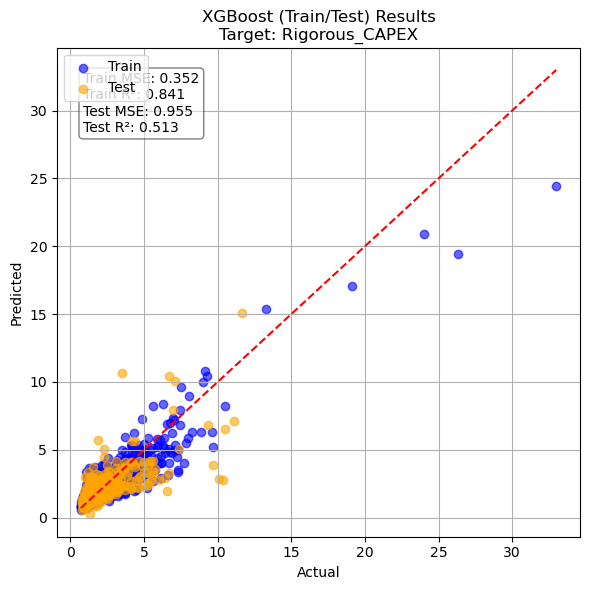

In [30]:
# XGBoost 실행
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)
xgb_result = run_xgboost_with_bayesian_optimization(X, y)  # 또는 'auto'

# 같은 시각화 함수 사용
plot_single_target_with_split(
    y_train_true=xgb_result['y_train'].flatten(),
    y_train_pred=xgb_result['y_train_pred'].flatten(),
    y_test_true=xgb_result['y_test'].flatten(),
    y_test_pred=xgb_result['y_test_pred'].flatten(),
    target_name=target_cols[0],  # 리스트 → 문자열
    train_mse=xgb_result['train_mse'][0],
    train_r2=xgb_result['train_r2'][0],
    test_mse=xgb_result['test_mse'][0],
    test_r2=xgb_result['test_r2'][0],
    title="XGBoost (Train/Test) Results"
)


In [36]:
y

array([ 1.0411,  2.1216,  3.3564,  1.6083,  4.9985,  0.7796,  1.6426,
        2.0584,  3.5415,  1.9983,  0.9419,  3.7745,  2.4439,  1.7506,
        2.5979,  0.8413,  0.9266,  0.8305,  0.9581,  1.3969,  0.5023,
        2.5345,  8.0784,  1.2348,  1.0617, 12.9642,  1.4446,  1.3113,
        1.3189,  3.7475,  1.6455,  2.5483,  3.3498,  2.1755,  4.3133,
        4.9209,  5.8431,  1.5813,  5.4984,  0.3166,  1.908 ,  1.3161,
        1.0752,  1.3341,  0.8173,  3.1432,  1.1257,  0.7724,  2.1078,
        0.8132,  5.4971,  2.2409,  1.1548,  0.7371,  1.3485,  7.8766,
        7.3   ,  1.8244,  1.8782,  1.3883, 10.3517,  1.0948,  0.3864,
        4.7105,  0.6877, 15.8619,  0.8758,  1.2879,  4.1769,  1.767 ,
        3.9532,  1.0477,  1.2014,  0.7387,  1.3556,  1.6391,  2.2057,
        2.1639,  1.0973,  0.9449,  1.6574,  0.9944,  4.9777,  1.3057,
        0.9477,  0.8362,  1.2852,  3.3595,  2.9547,  0.9453,  1.3121,
        0.5499, 11.5979,  5.6167,  3.5765,  3.0731,  1.8523,  1.4297,
        1.6082,  8.0

## Modelling-add Shortcut_OPEX

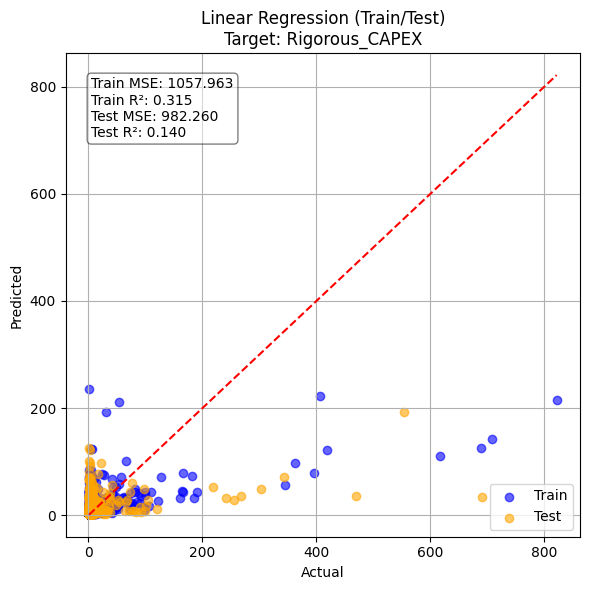

In [28]:

# 데이터프레임 불러오기 (예시)
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)

    # Linear Regression 실행
result = run_random_forest_with_validation(X, y)  # y.shape = (n_samples, 1)

plot_single_target_with_split(
    y_train_true=result['y_train'].flatten(),
    y_train_pred=result['y_train_pred'].flatten(),
    y_test_true=result['y_test'].flatten(),
    y_test_pred=result['y_test_pred'].flatten(),
    target_name='Rigorous_CAPEX',
    train_mse=result['train_mse'][0],
    train_r2=result['train_r2'][0],
    test_mse=result['test_mse'][0],
    test_r2=result['test_r2'][0],
    title="Linear Regression (Train/Test)"
)


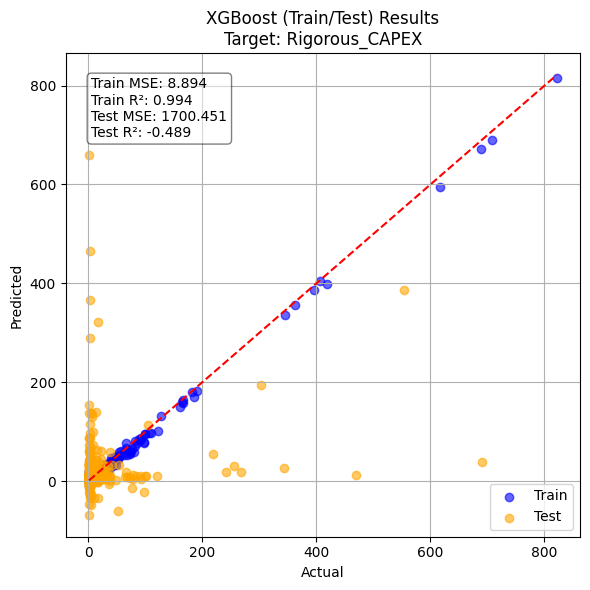

In [29]:
# XGBoost 실행
xgb_result = run_xgboost_with_validation(X, y, device='cpu')  # 또는 'auto'

# 같은 시각화 함수 사용
plot_single_target_with_split(
    y_train_true=xgb_result['y_train'].flatten(),
    y_train_pred=xgb_result['y_train_pred'].flatten(),
    y_test_true=xgb_result['y_test'].flatten(),
    y_test_pred=xgb_result['y_test_pred'].flatten(),
    target_name=target_cols[0],  # 리스트 → 문자열
    train_mse=xgb_result['train_mse'][0],
    train_r2=xgb_result['train_r2'][0],
    test_mse=xgb_result['test_mse'][0],
    test_r2=xgb_result['test_r2'][0],
    title="XGBoost (Train/Test) Results"
)